In [53]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 32
latent_dim = 100  # Size of the random noise vector
epochs = 35
lr = 0.0002
image_size = 28
channels = 1


In [54]:

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [55]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),  # Keep the same intermediate size
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, kernel_size=4, stride=2, padding=1),  # Output 3 channels for RGB
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)





In [56]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1),  # Input 3 channels
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)



In [57]:

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [58]:

# Training
for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        # Prepare real and fake labels
        real_labels = torch.ones(images.size(0), 1)
        fake_labels = torch.zeros(images.size(0), 1)
        
        # Train Discriminator
        optimizer_d.zero_grad()
        outputs = discriminator(images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()
        
        # Generate fake images
        z = torch.randn(images.size(0), latent_dim)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)  # Generator tries to fool discriminator
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{epochs}]  D Loss: {d_loss_real + d_loss_fake:.4f}, G Loss: {g_loss:.4f}')


Epoch [1/35]  D Loss: 0.0728, G Loss: 4.6586
Epoch [2/35]  D Loss: 0.5122, G Loss: 1.8924
Epoch [3/35]  D Loss: 0.3669, G Loss: 3.6295
Epoch [4/35]  D Loss: 0.2750, G Loss: 3.0780
Epoch [5/35]  D Loss: 0.5162, G Loss: 2.4116
Epoch [6/35]  D Loss: 0.1530, G Loss: 3.2535
Epoch [7/35]  D Loss: 0.3577, G Loss: 3.4076
Epoch [8/35]  D Loss: 0.4936, G Loss: 2.1181
Epoch [9/35]  D Loss: 0.1694, G Loss: 3.5679
Epoch [10/35]  D Loss: 0.5826, G Loss: 2.2309
Epoch [11/35]  D Loss: 0.3369, G Loss: 3.0878
Epoch [12/35]  D Loss: 0.1929, G Loss: 3.3163
Epoch [13/35]  D Loss: 0.3785, G Loss: 3.1225
Epoch [14/35]  D Loss: 0.3589, G Loss: 2.8882
Epoch [15/35]  D Loss: 0.8560, G Loss: 2.3462
Epoch [16/35]  D Loss: 0.1970, G Loss: 4.0161
Epoch [17/35]  D Loss: 0.5455, G Loss: 2.5395
Epoch [18/35]  D Loss: 0.2655, G Loss: 2.8435
Epoch [19/35]  D Loss: 0.3542, G Loss: 3.2291
Epoch [20/35]  D Loss: 0.4975, G Loss: 3.7115
Epoch [21/35]  D Loss: 0.1864, G Loss: 3.3199
Epoch [22/35]  D Loss: 0.2094, G Loss: 4.40

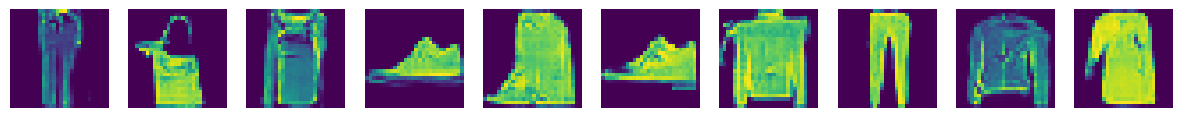

In [59]:
# Generating images
def generate_images(num_images):
    z = torch.randn(num_images, latent_dim)
    fake_images = generator(z)
    fake_images = fake_images.view(-1, channels, image_size, image_size)
    fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]
    return fake_images

# Display generated images
fake_images = generate_images(10)
fig, ax = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    ax[i].imshow(fake_images[i].detach().permute(1, 2, 0).cpu().numpy())  # Use RGB format
    ax[i].axis('off')
plt.show()

